In [2]:
import numpy as np
from scipy import signal
import math
import torch
from wonambi import Dataset
import matplotlib.pyplot as plt
import numpy as np
from scipy import fft
import pandas as pd
from glob import glob
import scipy
import sys
sys.path.append('..')
from neursa.preprocessing.preparation import parse_table_info, get_time_for_labels,\
get_labels, get_time_sensors
from neursa.data.dataset import SegmentsDataset

%load_ext autoreload
%autoreload 2
def fix_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
fix_seeds()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
recording_paths = sorted(glob('/data/anvlfilippova/Institution/*/'))[:-1]
info_path = '/data/anvlfilippova/Institution/SleepSensor_Recordings list.xlsx'

In [4]:
recording_paths_train = ['/data/anvlfilippova/Institution/Recording 0721001/',
 '/data/anvlfilippova/Institution/Recording 0721002/',
 '/data/anvlfilippova/Institution/Recording 0721003/',
#  '/data/anvlfilippova/Institution/Recording 0821004/',
 '/data/anvlfilippova/Institution/Recording 0821005/',
 '/data/anvlfilippova/Institution/Recording 0821006/',
 '/data/anvlfilippova/Institution/Recording 0921007/'
                        ]
recording_paths_valid = ['/data/anvlfilippova/Institution/Recording 0821004/', 
#                          '/data/anvlfilippova/Institution/Recording 1021009/'
                        ]

In [5]:
train_dataset = SegmentsDataset(recording_paths_train, 
                                segment_params={'window_size': 256*30, 'step_size':256*10})
valid_dataset = SegmentsDataset(recording_paths_valid, 
                               segment_params={'window_size': 256*30, 'step_size':256*10})
train_dataset.process_experiments()
valid_dataset.process_experiments()

Processing experiments: 100%|██████████| 1/1 [00:44<00:00, 44.58s/it]


In [8]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
from neursa.models.unet import UNet
dropout_rate = 0.2
channels = [7, 32, 64, 128, 256, 512, 1]
resnet = UNet(channels=channels)
from neursa.preprocessing.signal_processing import get_ecg_features

In [9]:
from torch import nn
import torch
class Model(nn.Module):
    def __init__(self, backbone, device):
        super().__init__()
        self.device = device
        self.backbone = backbone
        self.backbone.to(self.device)
        
    def forward(self, batch_data):
#         piezo1 = batch_data['piezo1'][:, :, None]
#         piezo2 = batch_data['piezo2'][:, :, None]
        piezo3 = batch_data['piezo3'][:, :, None]
        piezo4 = batch_data['piezo4'][:, :, None]
        piezo5 = batch_data['piezo5'][:, :, None]
        piezoA = batch_data['piezoA'][:, :, None]
        piezoB = batch_data['piezoB'][:, :, None]
        piezoEF = batch_data['piezoEF'][:, :, None]
        piezoDC = batch_data['piezoDC'][:, :, None]

        x = torch.cat((piezo3, piezo4, piezo5, 
                       piezoA, piezoB, piezoEF,
                       piezoDC), -1)
#         thorax = batch_data['thorax'][:, :, None]
#         abdomen = batch_data['abdomen'][:, :, None]
#         plethysmogram = batch_data['pleth'][:, :, None]
#         x = torch.cat((thorax, abdomen, plethysmogram), -1)
        x = x.permute(0, 2, 1).to(self.device)
        prediction = self.backbone(x)
        
        return prediction
    
    def train(self, train_loader, valid_loader, 
              criterion, optimizer, epochs):
        train_loss = []
        valid_loss = []
        for i in range(epochs):
            train_loss_epoch = self.train_epoch(train_loader, 
                                           criterion,
                                           optimizer)
            train_loss.append(train_loss_epoch)
            valid_loss_epoch = self.valid_epoch(valid_loader)
            valid_loss.append(valid_loss_epoch)
            
            print(f'Epoch {i+1}: train loss {train_loss_epoch}, valid loss {valid_loss_epoch}')
            
    def train_epoch(self, loader, criterion, optimizer):
        
        loss_epoch = []
        for batch in loader:
            prediction = self.forward(batch)
            target = batch['logs'][:, :, None].to(self.device)
            loss = criterion(prediction, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss = loss.cpu().detach().numpy()
            loss_epoch.append(loss)            
        return np.mean(loss_epoch)
    
    def valid_epoch(self, valid_loader):
        self.backbone.eval()
        loss_epoch = []
        with torch.no_grad():
            for batch in valid_loader:
                prediction = self.forward(batch)
                target = batch['logs'][:, :, None].to(self.device)
                loss = criterion(prediction, target)
                loss = loss.cpu().detach().numpy()
                loss_epoch.append(loss)
        return np.mean(loss_epoch)


                

In [10]:
m = Model(resnet, 'cuda:3')

criterion = nn.BCEWithLogitsLoss()

optim = torch.optim.Adam(m.backbone.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optim, 5, gamma=0.1, verbose=False)
loss = m.train(train_loader, valid_loader, criterion, optim, 8)

Epoch 1: train loss 0.429045706987381, valid loss 0.3500663936138153
Epoch 2: train loss 0.2848992347717285, valid loss 0.28023165464401245
Epoch 3: train loss 0.25922712683677673, valid loss 0.2750758230686188
Epoch 4: train loss 0.2344209849834442, valid loss 0.2847587764263153
Epoch 5: train loss 0.20336651802062988, valid loss 0.20919454097747803
Epoch 6: train loss 0.1254466325044632, valid loss 0.21797551214694977
Epoch 7: train loss 0.08305922150611877, valid loss 0.19712726771831512
Epoch 8: train loss 0.07144440710544586, valid loss 0.22045588493347168


In [11]:
segments = valid_dataset.get_processed_experiment(0)
batch_data = {name: torch.stack([segment[name] for segment in segments])
              for name in segments[0].keys()}

In [12]:
piezo3 = batch_data['piezo3'][:, :, None]
piezo4 = batch_data['piezo4'][:, :, None]
piezo5 = batch_data['piezo5'][:, :, None]
piezoA = batch_data['piezoA'][:, :, None]
piezoB = batch_data['piezoB'][:, :, None]
piezoEF = batch_data['piezoEF'][:, :, None]
piezoDC = batch_data['piezoDC'][:, :, None]

x = torch.cat((piezo3, piezo4, piezo5, 
               piezoA, piezoB, piezoEF,
               piezoDC), -1)
x = x.permute(0, 2, 1)




In [13]:
m.backbone.eval()
m.backbone.to('cpu')
with torch.no_grad():
    prediction = m.backbone(x)

In [14]:
prediction = nn.Sigmoid()(prediction).numpy()


In [15]:
from scipy.signal import find_peaks
peaks = find_peaks((prediction[200])[:, 0], distance = 0.8*256)[0]

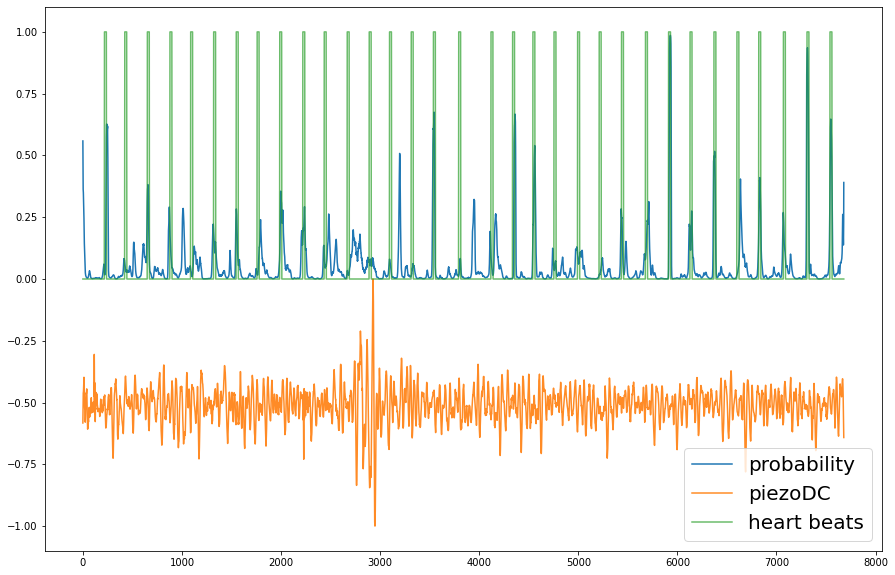

In [115]:
i = 46
from neursa.preprocessing.signal_processing import min_max_scaler

peaks = find_peaks((prediction[i]>0.5)[:, 0], distance = 0.8*256)[0]
plt.figure(figsize=(15,10))
plt.plot(prediction[i], label = 'probability')
piezo = 'piezoDC'
# plt.scatter(peaks, (prediction[i])[:, 0][peaks], marker='x', color = 'red', label = 'detected beats')
# plt.plot(batch_data['ecg'][i]/1000, label='ecg', alpha=0.2)
# plt.plot(batch_data['piezoDC'][i]/2000, label='piezo5', alpha=0.3)
# plt.plot(batch_data['piezo3'][i]/2000, label='piezo5', alpha=0.3)
scaled_piezo = min_max_scaler(batch_data[piezo][i].numpy()) - 1
plt.plot(scaled_piezo, label=piezo, alpha=0.9)
# plt.plot(batch_data['piezoDC'][i]/1000, label='piezo5', alpha=0.3)
plt.plot(batch_data['logs'][i], label='heart beats', alpha=0.7)



plt.legend(fontsize=20)


In [30]:
true_n_beats = []
predicted_n_beats = []

for i, window in enumerate(valid_dataset):
    _, peaks = get_ecg_features(window['ecg'].numpy())
    true_n_beats.append(peaks[0].shape[0])
    predicted_peaks = find_peaks(prediction[i][:, 0], distance = 0.8*256)[0]
    predicted_n_beats.append(predicted_peaks.shape[0])

In [31]:
from sklearn.metrics import r2_score 
r2_score(true_n_beats[100:], predicted_n_beats[100:])

0.9083915942057631

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(true_n_beats)
plt.plot(predicted_n_beats)